El objetivo de este proyecto es llevar a cabo un análsis estadístico de los casos de Covid-19 en México usando datos abiertos de la Secretaría de Salud reportados al 30/06/2020.

In [23]:
import pandas as pd;
from pandas import DataFrame as Df;
import matplotlib.pyplot as plt;
import numpy as np;
import math;
import seaborn as sns
sns.set()
#Cargamos los datos.
df=pd.read_csv("datos.csv",low_memory=False);

In [24]:
#Función que analiza los datos en frecuencias 
def analizaDatos(data,noncentered):
    dev=data.std(ddof=0);
    mean=data.mean();
    dataCenter=data-mean;
    frecuencyTable=pd.crosstab(index=dataCenter,columns="Frecuencia");
    for i in frecuencyTable.index:
        if abs(i)>3*dev:
            frecuencyTable=frecuencyTable.drop(i)
    if noncentered:
        frecuencyTable.index=frecuencyTable.index+mean;
    return(frecuencyTable);

#Función que genera gráfico de barras
def plotBar(frecuencyTable,multiFeature):
    if multiFeature:
      plt.bar(frecuencyTable.index,frecuencyTable["Frecuencia"]/sum(frecuencyTable["Frecuencia"]));
    else:
      plt.xlim(min(frecuencyTable.index),max(frecuencyTable.index));
      plt.bar(frecuencyTable.index,frecuencyTable["Frecuencia"]/sum(frecuencyTable["Frecuencia"]));
    
#Función que cuenta cuántas personas contagiadas y fallecidas cumplen con cierta característica.
def countByFeature(dataFeature,infected,multiFeature):
    frecuencyTableInfected=pd.crosstab(index=dataFeature,columns="Frecuencia");
    probabilitiesInfected=[];probabilitiesDeceased=[];
    for i in frecuencyTableInfected.index:
        probabilitiesInfected.append(frecuencyTableInfected["Frecuencia"][i]/sum(frecuencyTableInfected["Frecuencia"]));
    frecuencyTableDeceased=pd.crosstab(index=dataFeature[deceased],columns="Frecuencia");
    for i in frecuencyTableDeceased.index:
        probabilitiesDeceased.append(frecuencyTableDeceased["Frecuencia"][i]/sum(frecuencyTableDeceased["Frecuencia"]));
    frecuencyTableInfected["Probabilidad"]=probabilitiesInfected;
    frecuencyTableDeceased["Probabilidad"]=probabilitiesDeceased;
    if infected:
        plotBar(frecuencyTableInfected,multiFeature);
    else: 
        plotBar(frecuencyTableDeceased,multiFeature);
    return(frecuencyTableInfected,frecuencyTableDeceased)

#Función que genera términos de gamma.
def gammaFunction(x,alpha,beta):
    return pow(x,alpha-1)*math.exp(-x/beta)/(math.gamma(alpha)*pow(beta,alpha));

#Función que grafica distribución gamma.
def gammaDistribution(dataCounted):
    size=len(dataCounted.index);
    data=np.array(dataCounted.index*np.array(dataCounted['Frecuencia']));
    firstMean=sum(data)/sum(np.array(dataCounted['Frecuencia']));
    data=data/np.array(dataCounted['Frecuencia']);
    secondMean=sum((pow(data,2)*np.array(dataCounted['Frecuencia'])))/sum(np.array(dataCounted['Frecuencia']));
    alpha=pow(firstMean,2)/(secondMean-pow(firstMean,2));
    beta=(secondMean-pow(firstMean,2))/firstMean;
    domain=np.linspace(min(dataCounted.index),max(dataCounted.index),size);
    f=[];
    for i in domain:
        f.append(gammaFunction(i,alpha,beta))
    plt.plot(domain,f,'r',linewidth=2,label="Aproximación distribución Gamma")
    plt.legend(loc='upper right')
    return(f)

#Función que genera términos de normal.
def normal(x,mu,sigma):
    return 1/(pow(2*np.pi,.5)*sigma)*math.exp(-pow(x-mu,2)/(2*pow(sigma,2)));

#Función que grafica distribución normal.
def normalDistribution(dataCounted):
    size=len(dataCounted.index);
    data=np.array(dataCounted.index*np.array(dataCounted['Frecuencia']));
    firstMean=sum(data)/sum(np.array(dataCounted['Frecuencia']));
    data=data/np.array(dataCounted['Frecuencia']);
    secondMean=sum((pow(data,2)*np.array(dataCounted['Frecuencia'])))/sum(np.array(dataCounted['Frecuencia']));
    var=secondMean-pow(firstMean,2);
    std=pow(var,0.5)
    domain=np.linspace(min(dataCounted.index),max(dataCounted.index),size);
    f=[];
    for i in domain:
        f.append(normal(i,firstMean,std))
    plt.plot(domain,f,'g',linewidth=2,label="Aproximación distribución normal")
    plt.legend(loc='upper left')
    return(f)

#Función que grafica distribución exponencial.
def expDistribution(dataCounted):
    data=np.array(dataCounted.index*np.array(dataCounted['Frecuencia']));
    firstMean=sum(data)/sum(np.array(dataCounted['Frecuencia']));
    data=data/np.array(dataCounted['Frecuencia']);
    secondMean=sum((pow(data,2)*np.array(dataCounted['Frecuencia'])))/sum(np.array(dataCounted['Frecuencia']));
    alpha=1;
    beta=(secondMean-pow(firstMean,2))/firstMean;
    domain=np.linspace(min(dataCounted.index),max(dataCounted.index),1000);
    f=[];
    for i in domain:
        f.append(gammaFunction(i,alpha,beta))
    plt.plot(domain,f,'g',linewidth=2,label="Aproximación distribución exponencial")
    plt.legend(loc='upper left')
    return(f)
  
#Función que realiza la prueba de bondad de ajuste.
def fitTest(frecuencyTable,forecast):
    N=sum(frecuencyTable['Frecuencia']);
    dataTest=frecuencyTable.copy();
    dataTest['Pronóstico']=forecast;
    dataTest['Frecuencia']=dataTest['Frecuencia'];
    dataTest['Pronóstico']=dataTest['Pronóstico']*N;
    c=0;intervalMarks=[];
    for i in range(0,len(np.array(dataTest['Pronóstico']))):
        c=c+np.array(dataTest['Pronóstico'])[i]
        if c>5:
            c=0;
            intervalMarks.append(i);
    c=0;
    newForecast=[];
    newFrecuency=[];
    for i in intervalMarks:
        newForecast.append(sum(np.array(dataTest['Pronóstico'])[c:i+1]))
        newFrecuency.append(sum(np.array(dataTest['Frecuencia'])[c:i+1]))
        c=i+1;
    Chi=sum(pow((np.array(np.array(newForecast))-np.array(np.array(newFrecuency))),2)/np.array(np.array(newForecast)));
    degreesFreedomBase=len(newForecast);
    return(dataTest,intervalMarks,Chi,degreesFreedomBase)

Se obtiene el número total de contagiados y de fallecidos utilizando el campo días síntomas a defunción para el caso de los muertos y el resultado de la prueba para el caso de los contagios.

In [25]:
#Fallecidos.
deceased=df["DIAS_SINTOMAS_A_DEF"].dropna().index;

#Resultado Positivo.
positives=[];
for i in range(0,len(df["RESULTADO"])):
    if df["RESULTADO"][i]=='Positivo SARS-CoV-2':
        positives.append(i)

Se analiza el número de días que transcurrieron entre el contagio y la hospitalización, así como los días de síntomas a defunción. 

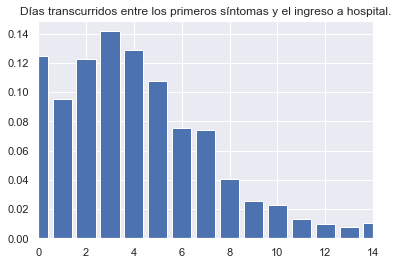

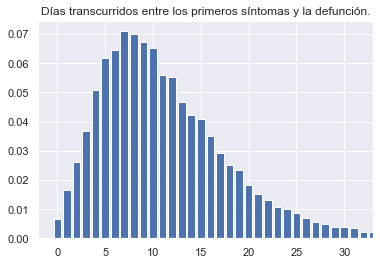

In [26]:
#Días desde Síntomas hasta ingreso a Hospital.
fig1,Graph1=plt.subplots();

Graph1.set_title("Días transcurridos entre los primeros síntomas y el ingreso a hospital.");
syntomsIngress=analizaDatos(df["DIAS_SINTOMAS_A_INGRESO"][positives],True);
plotBar(syntomsIngress,False);

#Días desde Síntomas hasta Defunción.
fig2,Graph2=plt.subplots();
Graph2.set_title("Días transcurridos entre los primeros síntomas y la defunción.");
syntomsDefunction=analizaDatos(df["DIAS_SINTOMAS_A_DEF"][positives],True);
plotBar(syntomsDefunction,False);

Se analiza la edad de los contagiados y de los fallecidos, debido a la distribución de los datos se propone lo siguiente:
<ul>
<li>Las edades de contagiados se asemejan a una distribución Gamma, por lo que se propone esta para el ajuste</li>
<li>Las edades de los fallecidos se asemejan más a una distribución normal que a una Gamma, se propone esta para hacer el ajuste</li>
</ul>

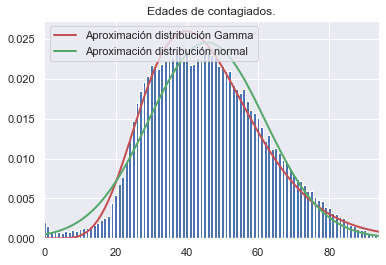

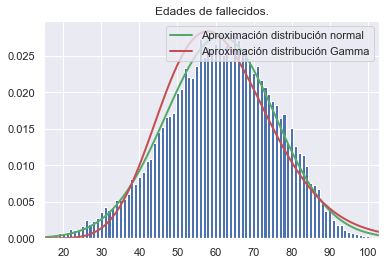

In [27]:
#Edad.
fig3,Graph3=plt.subplots();
Graph3.set_title("Edades de contagiados.");
infectedAge=analizaDatos(df["EDAD"][positives],True);
plotBar(infectedAge,False);
forecast=gammaDistribution(infectedAge);
normalDistribution(infectedAge)
dataTest,IntervalMarks,Chi,degreesFreedomBase=fitTest(infectedAge,forecast);###################################  Aquí están los resultados de la prueba de bondad para Gamma (datos: edad de infectados). 
                                                                                                                             #El estadístico es la variable Chi.

fig4,Graph4=plt.subplots();
Graph4.set_title("Edades de fallecidos.");
deceasedAge=analizaDatos(df["EDAD"][deceased],True);
plotBar(deceasedAge,False);
forecast2=normalDistribution(deceasedAge);
gammaDistribution(deceasedAge)
dataTest2,IntervalMarks2,Chi2,degreesFreedomBase2=fitTest(deceasedAge,forecast2);################################  Aquí están los resultados de la prueba de bondad para la Normal (datos: edad de fallecidos). 
                                                                                                                              #El estadístico es la variable Chi2.
    

Tras haber hecho estos ajustes se usa el concepto de bondad de ajuste en conjunto con la distribución ${\chi^{2}}$ para determinar con un ${95\%}$ de confianza si las distribuciones propuestas son adecuadas, estos son los valores de ${\chi^{2}}$ obtenidos. 

In [28]:
(Chi,Chi2)

(467734.0394431162, 590.4494600376124)

Al obtener los valores de ${p}$ de estos valores de ${\chi^{2}}$ se obtuvo 0 para ambos, por lo que se concluye que los ajustes propuestos no son adecuados con un ${95\%}$ de confianza.

Por último se analizan los contagios y fallecimientos totales y por sexo, así como fallecimientos y contagios de pacientes con tabaquismo

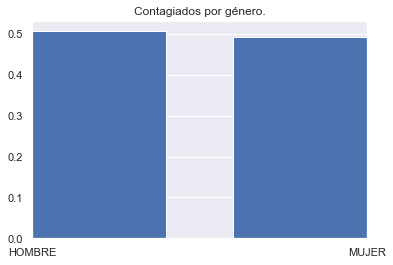

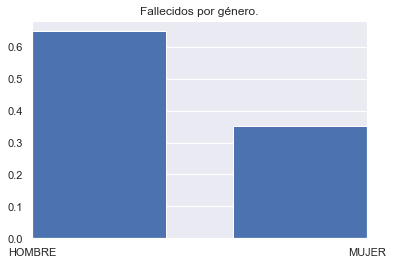

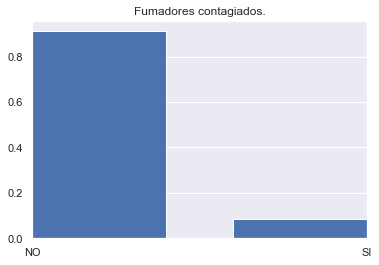

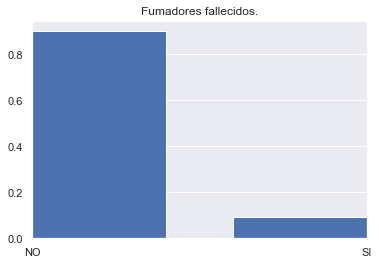

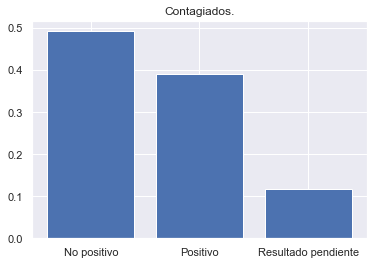

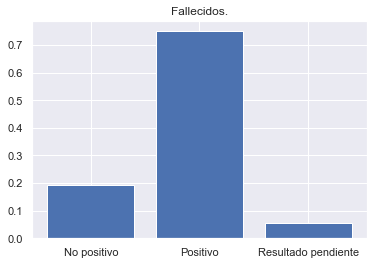

In [29]:
df['RESULTADO'] = df['RESULTADO'].replace(['Positivo SARS-CoV-2'],'Positivo')
df['RESULTADO'] = df['RESULTADO'].replace(['No positivo SARS-CoV-2'],'No positivo')


#Género.
fig5,Graph5=plt.subplots();
Graph5.set_title("Contagiados por género.");
infectedGender,deceasedGender=countByFeature(df["SEXO"],True,False)
fig6,Graph6=plt.subplots();
Graph6.set_title("Fallecidos por género.");
infectedGender,deceasedGender=countByFeature(df["SEXO"],False,False)

#Comorbilidad tabaquismo
fig7,Graph7=plt.subplots();
Graph7.set_title("Fumadores contagiados.");
infectedTabaquism,deceasedTabaquism=countByFeature(df["TABAQUISMO"],True,False)
fig8,Graph8=plt.subplots();
Graph8.set_title("Fumadores fallecidos.");
infectedTabaquism,deceasedTabaquism=countByFeature(df["TABAQUISMO"],False,False)

#Resultado en Prueba.
fig9,Graph9=plt.subplots();
Graph9.set_title("Contagiados.");
infectedTest,deceasedTest=countByFeature(df["RESULTADO"],True,True)
fig10,Graph10=plt.subplots();
Graph10.set_title("Fallecidos.");
infectedTest,deceasedTest=countByFeature(df["RESULTADO"],False,True)

In [30]:
infectedTabaquism

col_0,Frecuencia,Probabilidad
TABAQUISMO,,
NO,516678,0.911889
SE IGNORA,1907,0.003366
SI,48017,0.084746


In [31]:
deceasedTabaquism

col_0,Frecuencia,Probabilidad
TABAQUISMO,,
NO,32574,0.900431
SE IGNORA,263,0.007270
SI,3339,0.092299
